In [25]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
url = "https://zenodo.org/record/15853706/files/soil_phosphorus_adsorption_data.xlsx"
df = pd.read_excel(url)

df.head()

,id,code,Soil Classification,Soil texture,C,Si,S,pH,EC,CaCO3,...,1ppm_applied,2ppm_applied,4ppm_applied,6ppm_applied,10ppm_applied,1ppm_adsorbed,2ppm_adsorbed,4ppm_adsorbed,6ppm_adsorbed,10ppm_adsorbed
0,4,1053,Loamy,SCL,24,24,52,4.54,0.336,0.0,...,5.35860,10.7172,21.4344,32.1516,53.5860,5.216276,10.311822,20.682160,31.260304,52.135641
1,5,1055,Loamy,SL,20,28,52,5.76,0.449,0.0,...,5.39295,10.7859,21.5718,32.3577,53.9295,5.341016,10.336667,20.503187,30.689553,50.442041
2,6,1057,Loamy,CL,32,24,44,4.95,0.244,0.0,...,5.15250,10.3050,20.6100,30.9150,51.5250,5.058673,10.213389,20.295749,30.403460,50.937100
3,7,1059,Loamy,SCL,28,24,48,4.80,0.265,0.0,...,5.22120,10.4424,20.8848,31.3272,52.2120,5.174940,10.246448,20.405650,30.795369,50.953534
4,51,1069,Loamy,L,18,34,48,7.48,0.397,20.8,...,5.11815,10.2363,20.4726,30.7089,51.1815,4.479507,9.494015,18.376922,26.764393,39.527575


In [3]:
#convert to kg/ha
df['1ppm_adsorbed'] = 10 * df['1ppm_adsorbed']
df['2ppm_adsorbed'] = 10 * df['2ppm_adsorbed']
df['4ppm_adsorbed'] = 10 * df['4ppm_adsorbed']
df['6ppm_adsorbed'] = 10 * df['6ppm_adsorbed']
df['10ppm_adsorbed'] = 10 * df['10ppm_adsorbed']

In [4]:
# convert absorbed P to mg/kg of soil
df['1ppm_adsorbed'] = (df['1ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)
df['2ppm_adsorbed'] = (df['2ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)
df['4ppm_adsorbed'] = (df['4ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)
df['6ppm_adsorbed'] = (df['6ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)
df['10ppm_adsorbed'] = (df['10ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)

In [5]:
#selected features from feature engineering notebook
df_final_input = df[['S', 'C', 'pH', 'EC', 'Organic matter', 'P', 'Mg', 'Mn', 'Cu','1ppm_adsorbed', '2ppm_adsorbed', '4ppm_adsorbed', '6ppm_adsorbed', '10ppm_adsorbed']]

In [6]:
X = df_final_input.drop(columns=['1ppm_adsorbed', '2ppm_adsorbed', '4ppm_adsorbed', '6ppm_adsorbed', '10ppm_adsorbed'])
y = df_final_input[['1ppm_adsorbed', '2ppm_adsorbed', '4ppm_adsorbed', '6ppm_adsorbed', '10ppm_adsorbed']]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Initialize an XGBRegressor model with native multi-output support
model = xgb.XGBRegressor(n_estimators=100,
                     learning_rate=0.1,
                     tree_method="hist",
                     multi_strategy="multi_output_tree",
                     random_state=42)

In [9]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy='multi_output_tree', n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [10]:
y_pred = model.predict(X_test)

In [14]:
# Evaluate the model's performance using mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

Mean Absolute Error: 29.5812


In [16]:
# parameterize multi_output_xgboost_regressor
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import numpy as np

# Split your data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "tree_method": "hist",
        "multi_strategy": "multi_output_tree",
        "random_state": 42,
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    return mae

In [17]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100,  show_progress_bar=True)

[I 2025-07-10 10:26:49,092] A new study created in memory with name: no-name-48cc0752-1eaf-43f0-b066-5362472d5cee


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-10 10:26:49,344] Trial 0 finished with value: 31.80123610594527 and parameters: {'n_estimators': 143, 'learning_rate': 0.1388578989019355, 'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.6432618719527774, 'colsample_bytree': 0.6866440392058563, 'gamma': 1.4202248159552773}. Best is trial 0 with value: 31.80123610594527.
[I 2025-07-10 10:26:49,480] Trial 1 finished with value: 30.409053201860765 and parameters: {'n_estimators': 289, 'learning_rate': 0.019800868300230475, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8317283564011174, 'colsample_bytree': 0.8312955690198034, 'gamma': 3.889402298129825}. Best is trial 1 with value: 30.409053201860765.
[I 2025-07-10 10:26:49,626] Trial 2 finished with value: 32.272058825508566 and parameters: {'n_estimators': 128, 'learning_rate': 0.1254568662631264, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6628000109377189, 'colsample_bytree': 0.6743712670200226, 'gamma': 4.213630631477031}. Best is trial 1 with value

In [18]:
print("Best MAE:", study.best_value)
print("Best Hyperparameters:", study.best_params)

Best MAE: 27.10331573398556
Best Hyperparameters: {'n_estimators': 217, 'learning_rate': 0.08064462375541585, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.5515208065568229, 'colsample_bytree': 0.9938124997411584, 'gamma': 4.34666615521545}


In [20]:
# Initialize an XGBRegressor model with native multi-output support
model_multi = xgb.XGBRegressor(n_estimators=257,
                     learning_rate=0.13746153625886032,
                     tree_method="hist",
                     multi_strategy="multi_output_tree",
                     max_depth= 8,
                     min_child_weight = 2,
                     subsample= 0.8575279805203573,
                     colsample_bytree = 0.8978546705230994,
                     gamma = 2.4634384973190855,
                     random_state=42)

In [22]:
model_multi.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8978546705230994, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.4634384973190855,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.13746153625886032,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy='multi_output_tree', n_estimators=257, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
y_pred = model_multi.predict(X_test)

In [26]:
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)  # ✅ compute R²

print(f"MAE: {mae:.2f} mg/kg")
print(f"R²: {r2:.3f}")

MAE: 26.54 mg/kg
R²: 0.493


C:\Users\miatr\AppData\Local\Temp\ipykernel_27820\3017417176.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(y_test, y_pred, cmap='viridis', alpha=0.8, edgecolor='k')


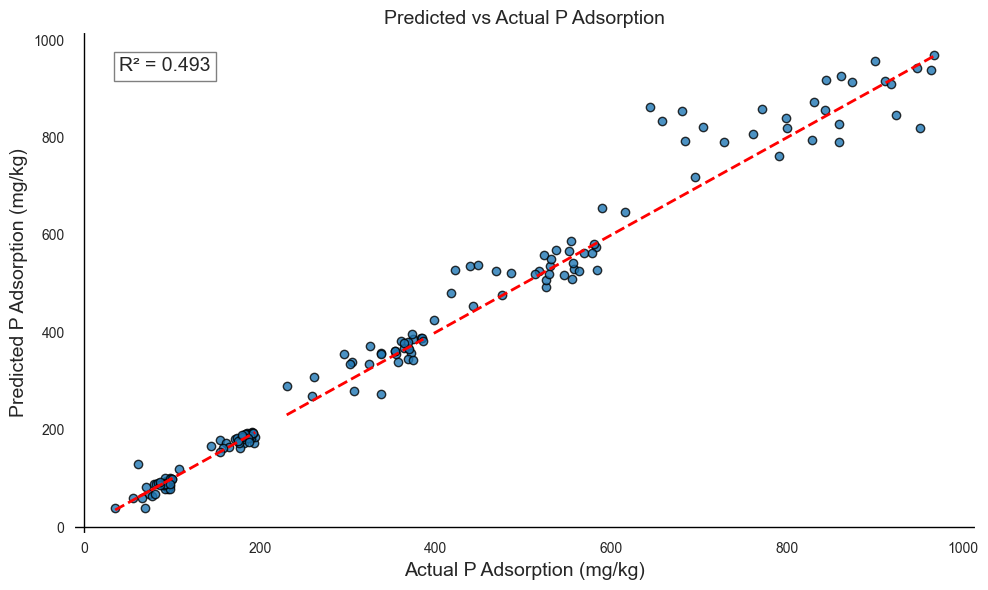

In [28]:
# Compute R²
r2 = r2_score(y_test, y_pred)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")
fig.patch.set_facecolor("white")

# Scatterplot: color by Ce
sc = ax.scatter(y_test, y_pred, cmap='viridis', alpha=0.8, edgecolor='k')

# 1:1 reference line
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Labels and title
ax.set_xlabel("Actual P Adsorption (mg/kg)", fontsize=14)
ax.set_ylabel("Predicted P Adsorption (mg/kg)", fontsize=14)
ax.set_title("Predicted vs Actual P Adsorption", fontsize=14)

ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

# Add R² score as text
ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes,
        fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='gray'))

# # Add colorbar for Ce values
# cbar = plt.colorbar(sc, ax=ax)
# cbar.set_label("Ce [mg/L]", fontsize=12)

# Grid and layout
ax.grid(True)
plt.tight_layout()
plt.show()

In [32]:
df

,id,code,Soil Classification,Soil texture,C,Si,S,pH,EC,CaCO3,...,1ppm_applied,2ppm_applied,4ppm_applied,6ppm_applied,10ppm_applied,1ppm_adsorbed,2ppm_adsorbed,4ppm_adsorbed,6ppm_adsorbed,10ppm_adsorbed
0,4,1053,Loamy,SCL,24,24,52,4.54,0.336,0.0,...,5.35860,10.7172,21.4344,32.1516,53.5860,97.281318,192.311074,385.713445,582.991310,972.307424
1,5,1055,Loamy,SL,20,28,52,5.76,0.449,0.0,...,5.39295,10.7859,21.5718,32.3577,53.9295,98.973222,191.546560,379.940162,568.701526,934.730645
2,6,1057,Loamy,CL,32,24,44,4.95,0.244,0.0,...,5.15250,10.3050,20.6100,30.9150,51.5250,98.115773,198.094354,393.647327,589.691998,987.953353
3,7,1059,Loamy,SCL,28,24,48,4.80,0.265,0.0,...,5.22120,10.4424,20.8848,31.3272,52.2120,99.050167,196.120610,390.571301,589.434168,975.268519
4,51,1069,Loamy,L,18,34,48,7.48,0.397,20.8,...,5.11815,10.2363,20.4726,30.7089,51.1815,87.465631,185.377546,358.822763,522.594233,771.804641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,32,2488,Clayey,C,42,36,22,7.90,0.397,12.3,...,4.43115,8.8623,17.7246,26.5869,44.3115,99.935600,199.871200,396.341592,588.996450,985.402995
143,60,2489,Loamy,CL,28,36,36,7.91,0.433,41.3,...,4.60290,9.2058,18.4116,27.6174,46.0290,95.447497,190.085505,355.418967,584.271491,950.883228
144,15,2490,Loamy,L,20,38,42,6.78,0.938,0.0,...,5.32425,10.6485,21.2970,31.9455,53.2425,46.357130,128.034486,301.255873,468.600032,804.519561
145,42,2491,Loamy,SiL,22,50,28,7.64,0.306,19.0,...,5.04945,10.0989,20.1978,30.2967,50.4945,93.415804,193.634223,377.579673,565.391152,888.573396


In [34]:
# Ce levels and target columns
Ce_values = [1, 2, 4, 6, 10]
q_columns = ['1ppm_adsorbed', '2ppm_adsorbed', '4ppm_adsorbed', '6ppm_adsorbed', '10ppm_adsorbed']

# Separate your features by type
string_features = ['Soil Classification', 'Soil texture']
float_features = ['S', 'C', 'pH', 'EC', 'Organic matter', 'P', 'Mg', 'Mn', 'Cu']
all_features = string_features + float_features

rows = []

for _, row in df.iterrows():
    string_values = row[string_features].astype(str).tolist()
    float_values = row[float_features].astype(float).tolist()

    for i, Ce in enumerate(Ce_values):
        q = float(row[q_columns[i]])  # Ensure q is also float
        combined = string_values + float_values + [Ce, q]
        rows.append(combined)

# Create DataFrame
columns = string_features + float_features + ['Ce', 'q']
df_seq = pd.DataFrame(rows, columns=columns)

In [35]:
df_seq

,Soil Classification,Soil texture,S,C,pH,EC,Organic matter,P,Mg,Mn,Cu,Ce,q
0,Loamy,SCL,52.0,24.0,4.54,0.336,0.95,6.761,1.82,65.07,3.09,1,97.281318
1,Loamy,SCL,52.0,24.0,4.54,0.336,0.95,6.761,1.82,65.07,3.09,2,192.311074
2,Loamy,SCL,52.0,24.0,4.54,0.336,0.95,6.761,1.82,65.07,3.09,4,385.713445
3,Loamy,SCL,52.0,24.0,4.54,0.336,0.95,6.761,1.82,65.07,3.09,6,582.991310
4,Loamy,SCL,52.0,24.0,4.54,0.336,0.95,6.761,1.82,65.07,3.09,10,972.307424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,Clayey,C,30.0,42.0,7.70,0.459,2.07,4.305,1.63,2.36,2.43,1,99.614799
731,Clayey,C,30.0,42.0,7.70,0.459,2.07,4.305,1.63,2.36,2.43,2,197.454758
732,Clayey,C,30.0,42.0,7.70,0.459,2.07,4.305,1.63,2.36,2.43,4,392.712927
733,Clayey,C,30.0,42.0,7.70,0.459,2.07,4.305,1.63,2.36,2.43,6,581.627180


In [36]:
def langmuir(Ce, Qm, K):
    return (Qm * K * Ce) / (1 + K * Ce)

In [37]:
Ce_values = df_seq["Ce"].values

In [38]:
q_values = df_seq["q"].values

In [39]:
popt, pcov = curve_fit(langmuir, Ce_values, q_values, p0=[20, 0.1])  # Initial guesses for Qm and K
Qm_fit, K_fit = popt  # Extract fitted parameters

In [40]:
Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
q_fit = langmuir(Ce_fit, Qm_fit, K_fit)

In [43]:
print(Qm_fit), print(K_fit)

10879.685242511825
0.008411835848268344


(None, None)

In [44]:
df = df_seq.copy()

C:\Users\miatr\AppData\Local\Temp\ipykernel_27820\2432015398.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap("tab10")


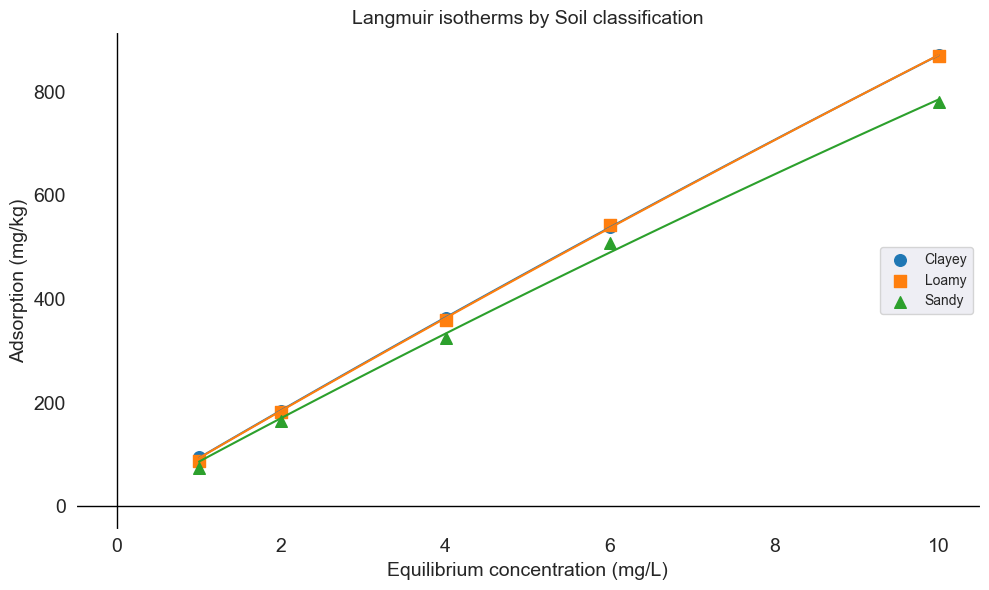

  Soil texture            Qm         K
0       Clayey  11822.862867  0.007950
1        Loamy  12899.800193  0.007242
2        Sandy   8231.606949  0.010547


In [46]:
# Group by soil class and rate
mean_df = df.groupby(['Soil Classification', 'Ce'], as_index=False)['q'].mean()
soil_classes = mean_df['Soil Classification'].unique()

# Setup
markers = ['o', 's', '^']
color_map = plt.cm.get_cmap("tab10")
params_by_soil = {}

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")
fig.patch.set_facecolor("white")

for idx, soil in enumerate(soil_classes):
    sub = mean_df[mean_df['Soil Classification'] == soil]
    Ce = sub['Ce'].values
    q = sub['q'].values

    try:
        popt, _ = curve_fit(langmuir, Ce, q, p0=[20, 0.1])
        Qm, K = popt
        params_by_soil[soil] = (Qm, K)

        Ce_fit = np.linspace(min(Ce), max(Ce), 100)
        q_fit = langmuir(Ce_fit, Qm, K)

        marker = markers[idx % len(markers)]
        color = color_map(idx % 10)

        ax.scatter(Ce, q, label=f"{soil}", marker=marker, color=color, s=70)
        ax.plot(Ce_fit, q_fit, label=f"", color=color)

    except RuntimeError:
        print(f"Could not fit Langmuir model for {soil}")

# Axes lines
ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

# Axis labels and style
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel("Equilibrium concentration (mg/L)", fontsize=14)
ax.set_ylabel("Adsorption (mg/kg)", fontsize=14)
ax.set_title("Langmuir isotherms by Soil classification", fontsize=14)
ax.legend(loc="best", fontsize=10)
ax.grid(True)
plt.tight_layout()
plt.show()

# Show fitted parameters
params_table = pd.DataFrame([
    {"Soil texture": soil, "Qm": Qm, "K": K}
    for soil, (Qm, K) in params_by_soil.items()
])
print(params_table)


C:\Users\miatr\AppData\Local\Temp\ipykernel_27820\576966192.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap("tab10")  # Color cycle


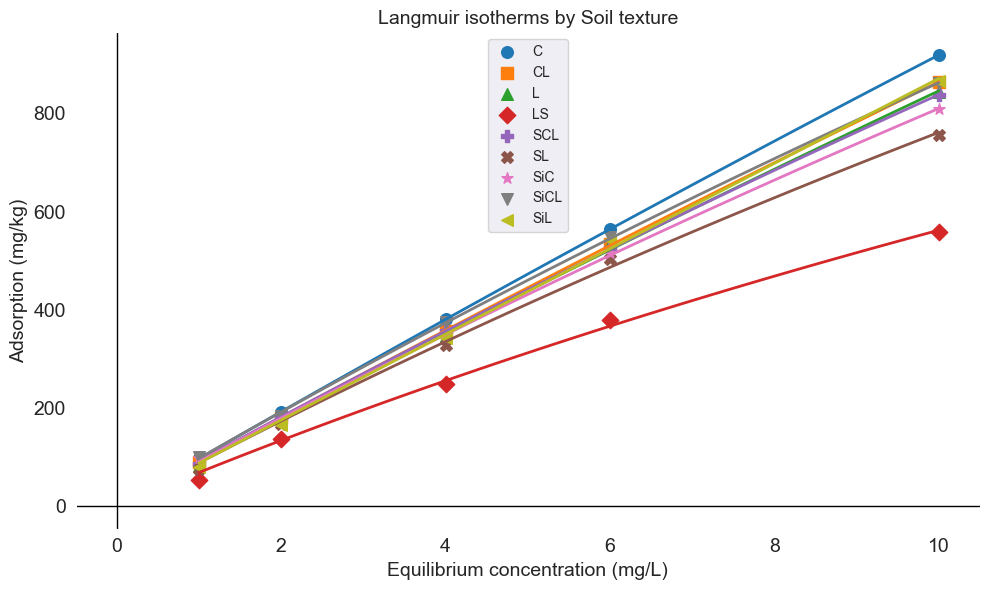

  Soil texture             Qm         K
0            C   16366.060452  0.005949
1           CL   14959.935096  0.006133
2            L   12055.405006  0.007546
3           LS    2803.550439  0.025078
4          SCL    8517.246376  0.010916
5           SL    4998.744129  0.017967
6          SiC    6686.859599  0.013785
7         SiCL    6840.715529  0.014428
8          SiL  104510.205312  0.000841


In [47]:
# Group by soil class and rate
mean_df = df.groupby(['Soil texture', 'Ce'], as_index=False)['q'].mean()
soil_classes = mean_df['Soil texture'].unique()

# Unique markers for soil classes (use any style you like)
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '<', '>', 'H', 'd']
color_map = plt.cm.get_cmap("tab10")  # Color cycle

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")  # Set plot background to white
fig.patch.set_facecolor("white")  # Set figure background to white

params_by_soil = {}

for idx, soil in enumerate(mean_df['Soil texture'].unique()):
    sub_df = mean_df[mean_df['Soil texture'] == soil]
    Ce_values = sub_df['Ce'].values
    q_values = sub_df['q'].values

    try:
        popt, _ = curve_fit(langmuir, Ce_values, q_values, p0=[20, 0.1])
        Qm_fit, K_fit = popt
        params_by_soil[soil] = (Qm_fit, K_fit)

        Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
        q_fit = langmuir(Ce_fit, Qm_fit, K_fit)

        marker = markers[idx % len(markers)]
        color = color_map(idx % 10)

        ax.scatter(Ce_values, q_values, label=f"{soil}", marker=marker, color=color, s=70)
        ax.plot(Ce_fit, q_fit, label=f"", color=color, linewidth=2)

    except RuntimeError:
        print(f"Could not fit Langmuir for {soil}")

ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

ax.tick_params(axis='both', which='major', labelsize=14)

# Labels and title
ax.set_xlabel("Equilibrium concentration (mg/L)", fontsize=14)
ax.set_ylabel("Adsorption (mg/kg)", fontsize=14)
ax.set_title("Langmuir isotherms by Soil texture", fontsize=14)
ax.legend(loc="best", fontsize=10)
ax.grid(True)
plt.tight_layout()
plt.show()

# Show fitted parameters
params_table = pd.DataFrame([
    {"Soil texture": soil, "Qm": Qm, "K": K}
    for soil, (Qm, K) in params_by_soil.items()
])
print(params_table)

In [48]:
df = df.rename(columns={'Organic matter': 'Organic_matter'})

In [49]:
# multiple regression equations
import statsmodels.formula.api as smf

# Define predictors and target variable
input_vars = ['S', 'C', 'pH', 'EC', 'Organic_matter', 'P', 'Mg', 'Mn', 'Cu', 'Ce']
target_var = 'q'

# Clean data (drop rows with missing values in relevant columns)
df_clean = df.dropna(subset=input_vars + [target_var, 'Soil Classification'])

# Create and store regression equations by soil class
for soil_class in df_clean['Soil Classification'].unique():
    sub_df = df_clean[df_clean['Soil Classification'] == soil_class]

    # Construct the regression formula
    formula = f"{target_var} ~ " + " + ".join(input_vars)

    # Fit the model
    model = smf.ols(formula=formula, data=sub_df).fit()

    # Print regression equation
    print(f"\nSoil class: {soil_class}")
    print("Regression equation:")

    eq = f"{target_var} = {model.params[0]:.3f}"
    for var, coef in model.params[1:].items():
        sign = "+" if coef >= 0 else "-"
        eq += f" {sign} {abs(coef):.3f}*{var}"

    print(eq)



Soil class: Loamy
Regression equation:
q = 47.999 - 1.152*S + 1.899*C - 4.339*pH + 4.016*EC - 0.929*Organic_matter - 1.924*P - 3.491*Mg + 0.875*Mn - 0.309*Cu + 86.910*Ce

Soil class: Sandy
Regression equation:
q = 192.069 - 2.398*S - 3.571*C - 5.894*pH + 16.338*EC - 1.668*Organic_matter - 4.243*P + 15.733*Mg + 1.379*Mn + 3.640*Cu + 78.842*Ce

Soil class: Clayey
Regression equation:
q = 308.496 - 0.978*S + 1.462*C - 31.008*pH - 25.111*EC - 25.684*Organic_matter + 3.210*P + 0.560*Mg - 3.920*Mn - 1.009*Cu + 86.246*Ce


C:\Users\miatr\AppData\Local\Temp\ipykernel_27820\1857421814.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eq = f"{target_var} = {model.params[0]:.3f}"
C:\Users\miatr\AppData\Local\Temp\ipykernel_27820\1857421814.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eq = f"{target_var} = {model.params[0]:.3f}"
C:\Users\miatr\AppData\Local\Temp\ipykernel_27820\1857421814.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eq =

In [50]:
df = df.rename(columns={'C': 'Clay'})

In [51]:
#Anova
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Ensure 'Organic_matter' is renamed and clean the data
df = df.rename(columns={'Organic matter': 'Organic_matter'})
input_vars = ['S', 'Clay', 'pH', 'EC', 'Organic_matter', 'P', 'Mg', 'Mn', 'Cu', 'Ce']
target_var = 'q'

df_clean = df.dropna(subset=input_vars + [target_var, 'Soil Classification'])

# Full model: includes interaction between soil class and predictors
interaction_terms = ' + '.join([f'C(Q("Soil Classification")):{var}' for var in input_vars])
formula_full = f"{target_var} ~ C(Q('Soil Classification')) + " + ' + '.join(input_vars) + ' + ' + interaction_terms
model_full = smf.ols(formula=formula_full, data=df_clean).fit()

# Reduced model: no interaction terms (assumes same slopes for all classes)
formula_reduced = f"{target_var} ~ C(Q('Soil Classification')) + " + ' + '.join(input_vars)
model_reduced = smf.ols(formula=formula_reduced, data=df_clean).fit()

# Compare models using ANOVA (F-test)
anova_result = sm.stats.anova_lm(model_reduced, model_full)
print(anova_result)


   df_resid           ssr  df_diff        ss_diff         F        Pr(>F)
0     722.0  3.267469e+06      0.0            NaN       NaN           NaN
1     702.0  2.359131e+06     20.0  908338.589969  13.51459  5.981600e-38


In [53]:
# Step 1: Define Langmuir parameters for Soil texture and Soil classification
# Step 1: Define Langmuir parameters for Soil texture and Soil classification
texture_params = {
    "C":    (16366.058934, 0.005949),
    "CL":   (14959.937394, 0.006133),
    "L":    (12055.405405, 0.007546),
    "LS":   (2803.550024, 0.025078),
    "SCL":  (8517.247429, 0.010916),
    "SL":   (4998.743467, 0.017967),
    "SiC":  (6686.859738, 0.013785),
    "SiCL": (6840.715595, 0.014428),
    "SiL":  (104509.787289, 0.000841)
}


classification_params = {
    "Clayey": (11822.862819, 0.007950),
    "Loamy":  (12899.800247, 0.007242),
    "Sandy":  (8231.606950, 0.010547)
}


# Step 2: Define Langmuir function
def langmuir(Ce, Qm, K):
    return (Qm * K * Ce) / (1 + K * Ce)

# Step 3: Calculate adsorption per row
def calculate_adsorption(row):
    Ce = row['Ce']
    texture = row['Soil texture']
    classification = row['Soil Classification']

    if texture in texture_params:
        Qm, K = texture_params[texture]
    elif classification in classification_params:
        Qm, K = classification_params[classification]
    else:
        return np.nan  # Or some fallback default

    return langmuir(Ce, Qm, K)

# Step 4: Apply the function to create a new column
df['P_Adsorption_Langmuir'] = df.apply(calculate_adsorption, axis=1)

df['Used Texture Params'] = df['Soil texture'].isin(texture_params.keys())


In [55]:
print(df.head())

  Soil Classification Soil texture     S  Clay    pH     EC  Organic_matter  \
0               Loamy          SCL  52.0  24.0  4.54  0.336            0.95   
1               Loamy          SCL  52.0  24.0  4.54  0.336            0.95   
2               Loamy          SCL  52.0  24.0  4.54  0.336            0.95   
3               Loamy          SCL  52.0  24.0  4.54  0.336            0.95   
4               Loamy          SCL  52.0  24.0  4.54  0.336            0.95   

       P    Mg     Mn    Cu  Ce           q  P_Adsorption_Langmuir  \
0  6.761  1.82  65.07  3.09   1   97.281318              91.970325   
1  6.761  1.82  65.07  3.09   2  192.311074             181.975653   
2  6.761  1.82  65.07  3.09   4  385.713445             356.337951   
3  6.761  1.82  65.07  3.09   6  582.991310             523.554887   
4  6.761  1.82  65.07  3.09  10  972.307424             838.240407   

   Used Texture Params  
0                 True  
1                 True  
2                 True  
3   